In [1]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.datasets import mnist
import keras.backend as K
import matplotlib.pyplot as plt

K.set_image_data_format('channels_last')

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape((x_train.shape[0],) + (28, 28, 1))
print(x_train.shape)

(60000, 28, 28, 1)


In [3]:
class Gan:
    def __init__(self, img_data):
        img_size = img_data.shape[1]
        channel = img_data.shape[3] if len(img_data.shape) >= 4 else 1
    
        self.img_data = img_data
        self.input_shape = (img_size, img_size, channel)
    
        self.img_rows = img_size
        self.img_cols = img_size
        self.channel = channel
        self.noise_dim = 100
    
        # Create D and G
        self.create_d()
        self.create_g()
    
        # Build model to train D
        optimizer = Adam(learning_rate=0.0008)
        self.D.compile(loss='binary_crossentropy', optimizer=optimizer)
    
        # Build model to train G
        optimizer = Adam(learning_rate=0.0004)
        self.D.trainable = False
        self.AM = Sequential()
        self.AM.add(self.G)
        self.AM.add(self.D)
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer)
  
    def create_d(self):
        self.D = Sequential(name='Discriminator')
        
        dropout = 0.4
        
        self.D.add(Conv2D(64, 5, strides=2, input_shape=self.input_shape,
                          padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(128, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(256, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(512, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        
        self.D.summary()
        return self.D
  
    def create_g(self):
        self.G = Sequential(name='Generator')
        
        dropout = 0.4
        
        self.G.add(Dense(7*7*256, input_dim=self.noise_dim))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((7, 7, 256)))
        self.G.add(Dropout(dropout))
        self.G.add(UpSampling2D()) # 7 7 256 -> 14 14 256
        
        self.G.add(Conv2DTranspose(128, 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        self.G.add(Conv2DTranspose(64, 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(32, 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(1, 5, strides=1, padding='same'))
        self.G.add(Activation('sigmoid'))
        
        self.G.summary()
        return self.G
  
    def train(self, batch_size=100):
        # Pick image data randomly
        images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size=batch_size), :, :, :]
    
        # Generate images from noise
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_dim])
        images_fake = self.G.predict(noise)
    
        # Train D
        x = np.concatenate((images_train, images_fake))
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0
        self.D.trainable = True
        d_loss = self.D.train_on_batch(x, y)
    
        # Train G
        y = np.ones([batch_size, 1])
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_dim])
        self.D.trainable = False
        g_loss = self.AM.train_on_batch(noise, y)
    
        return d_loss, g_loss, images_fake
    

In [4]:
# Init network
gan = Gan(x_train)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)       

Epoch: 1
iteration:0 / iterations:600
4/4 [==============================] - 0s 40ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

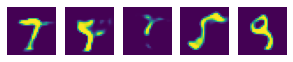

Epoch: 2
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

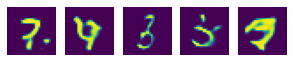

Epoch: 3
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

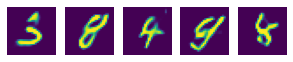

Epoch: 4
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

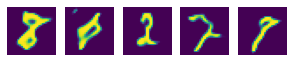

Epoch: 5
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

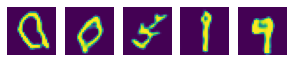

Epoch: 6
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

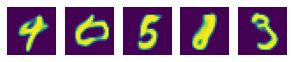

Epoch: 7
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

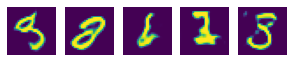

Epoch: 8
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

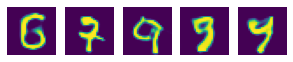

Epoch: 9
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

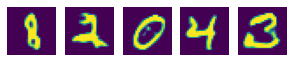

Epoch: 10
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [===============

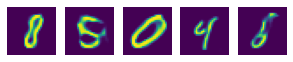

Epoch: 11
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 4ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

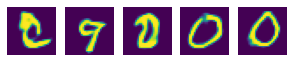

Epoch: 12
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

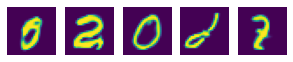

Epoch: 13
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

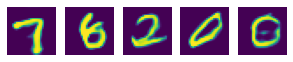

Epoch: 14
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

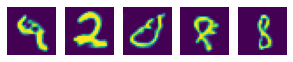

Epoch: 15
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 4ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

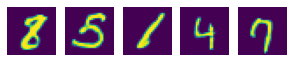

Epoch: 16
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

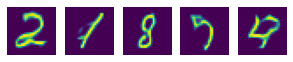

Epoch: 17
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

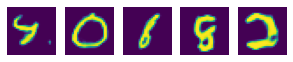

Epoch: 18
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

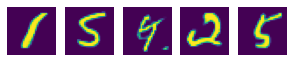

Epoch: 19
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

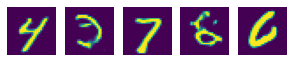

Epoch: 20
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

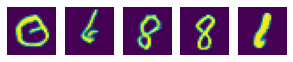

Epoch: 21
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

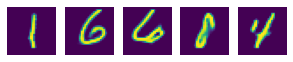

Epoch: 22
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

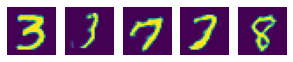

Epoch: 23
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

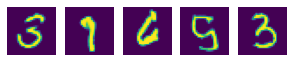

Epoch: 24
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

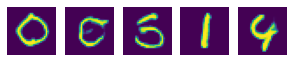

Epoch: 25
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

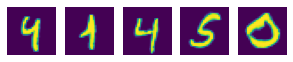

Epoch: 26
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [==============

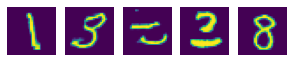

Epoch: 27
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:227 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:228 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:229 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:230 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:231 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:232 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:233 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:234 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:235 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:377 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:378 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:379 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:380 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:381 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:382 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:383 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:384 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:385 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:527 / iterations:600
4/4 [==============================] - 0s 1ms/step
img.shape (100, 28, 28, 1)
iteration:528 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:529 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:530 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:531 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:532 / iterations:600
4/4 [==============================] - 0s 340us/step
img.shape (100, 28, 28, 1)
iteration:533 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:534 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:535 / iterations:600
4/4 [============

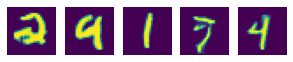

Epoch: 28
iteration:0 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600


4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [===========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [==================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [================

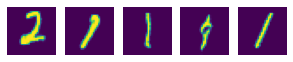

Epoch: 29
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600


4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [========================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [==================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [=================

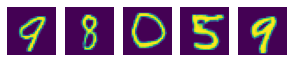

Epoch: 30
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 1ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 670us/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [===================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [================

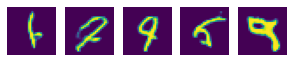

Epoch: 31
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600
4

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [===========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [===============

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [===================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [=================

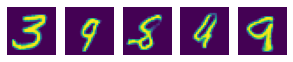

Epoch: 32
iteration:0 / iterations:600
4/4 [==============================] - 0s 670us/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [===============

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [==================

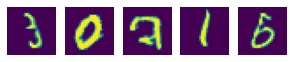

Epoch: 33
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600


4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [==========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [==================

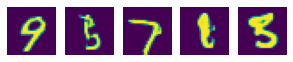

Epoch: 34
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600


4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 5ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [===============

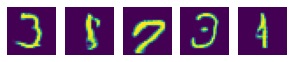

Epoch: 35
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600


4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [==========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [==============

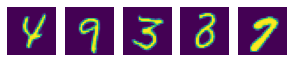

Epoch: 36
iteration:0 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600
4/

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [===============

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [================

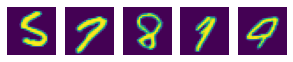

Epoch: 37
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600


4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [================

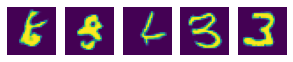

Epoch: 38
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=======================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [==================

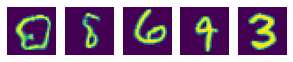

Epoch: 39
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=========================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [===============

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [================

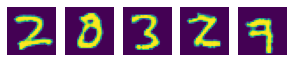

Epoch: 40
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600
4

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [===========================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [=================

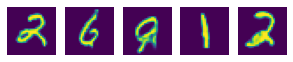

Epoch: 41
iteration:0 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600
4/

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [==========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [==============

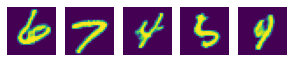

Epoch: 42
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:60

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [==================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [=================

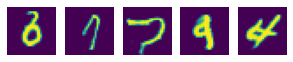

Epoch: 43
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600


4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=========================

iteration:152 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / itera

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [=================

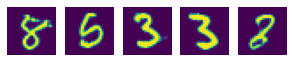

Epoch: 44
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [==========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [==================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [================

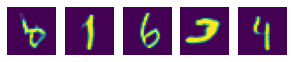

Epoch: 45
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600
4/4

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [==========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [==============

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [=================

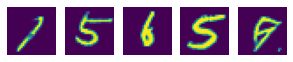

Epoch: 46
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600
4

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [========================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [=================

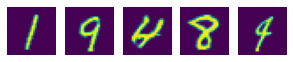

Epoch: 47
iteration:0 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600
4

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [===========================

iteration:152 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 1ms/step
img.shape (100, 28, 28, 1)
iteration:161 / itera

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [===============

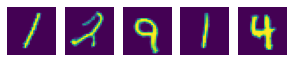

Epoch: 48
iteration:0 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 2ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [===============

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [===============

4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [================

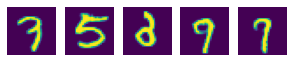

Epoch: 49
iteration:0 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600


4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [==========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [===============

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [===============

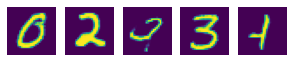

Epoch: 50
iteration:0 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:1 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:2 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:3 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:4 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:5 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:6 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:7 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:8 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:9 / iterations:600
4

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:77 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:78 / iterations:600
4/4 [==============================] - 0s 4ms/step
img.shape (100, 28, 28, 1)
iteration:79 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:80 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:81 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:82 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:83 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:84 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:85 / iterations:600
4/4 [=========================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:153 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:154 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:155 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:156 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:157 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:158 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:159 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:160 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:161 / iterations:600
4/4 [================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:303 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:304 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:305 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:306 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:307 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:308 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:309 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:310 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:311 / iterations:600
4/4 [=================

4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:453 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:454 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:455 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:456 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:457 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:458 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:459 / iterations:600
4/4 [==============================] - 0s 3ms/step
img.shape (100, 28, 28, 1)
iteration:460 / iterations:600
4/4 [==============================] - 0s 0s/step
img.shape (100, 28, 28, 1)
iteration:461 / iterations:600
4/4 [================

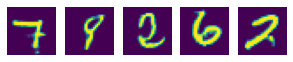

In [6]:
# Some parameters
epochs = 50
sample_size = 5
batch_size = 100
iterations = x_train.shape[0] // batch_size

imgs = [] # Save images
total_d_losses = []
total_g_losses = []

for epoch in range(0, epochs):
    print("Epoch:", epoch + 1)
  
    total_d_loss = 0.0
    total_g_loss = 0.0
  
    for iteration in range(0, iterations):
        print('iteration:{} / iterations:{}'.format(iteration, iterations))
        d_loss, g_loss, img = gan.train(batch_size)
        total_d_loss += d_loss
        total_g_loss += g_loss
        print('img.shape', img.shape)
        imgs.append(img)
        
  
    total_d_loss /= iterations
    total_g_loss /= iterations
    
    total_d_losses.append(total_d_loss)
    total_g_losses.append(total_g_loss)
  
    print("D Loss: {}, AM Loss: {}".format(total_d_loss, total_g_loss))
    
    # Show generated images
    fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
    for i in range(0, sample_size):
        ax[i].set_axis_off()
        ax[i].imshow(img[i].reshape((28, 28)))
    plt.show()
    plt.close(fig);


In [7]:
imgs[2999].shape

(100, 28, 28, 1)

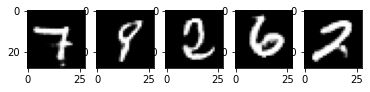

In [8]:
plt.subplot(1, 5, 1)
plt.imshow(imgs[29999][0].reshape(28,28), cmap='gray')
# 599 = 600(iterations)*1(epoch) -1

plt.subplot(1, 5, 2)
plt.imshow(imgs[29999][1].reshape(28,28), cmap='gray')

plt.subplot(1, 5, 3)
plt.imshow(imgs[29999][2].reshape(28,28), cmap='gray')

plt.subplot(1, 5, 4)
plt.imshow(imgs[29999][3].reshape(28,28), cmap='gray')

plt.subplot(1, 5, 5)
plt.imshow(imgs[29999][4].reshape(28,28), cmap='gray')

Epoch 1


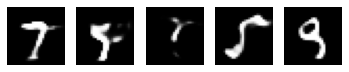

Epoch 2


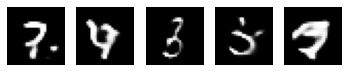

Epoch 3


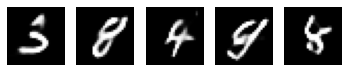

Epoch 4


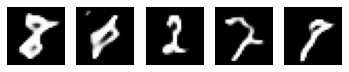

Epoch 5


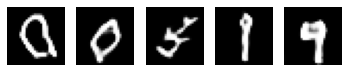

Epoch 6


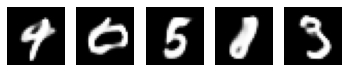

Epoch 7


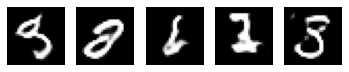

Epoch 8


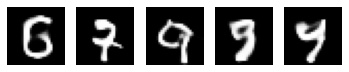

Epoch 9


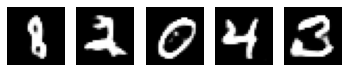

Epoch 10


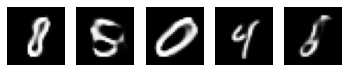

Epoch 11


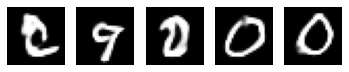

Epoch 12


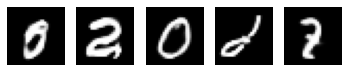

Epoch 13


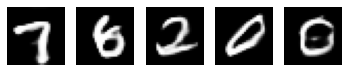

Epoch 14


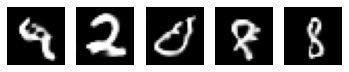

Epoch 15


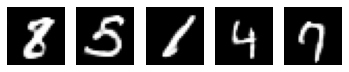

Epoch 16


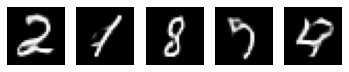

Epoch 17


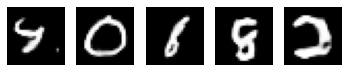

Epoch 18


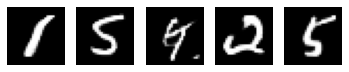

Epoch 19


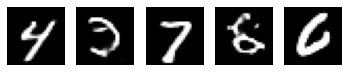

Epoch 20


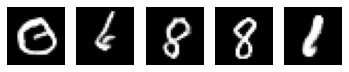

Epoch 21


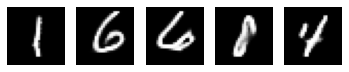

Epoch 22


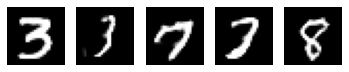

Epoch 23


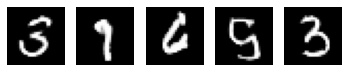

Epoch 24


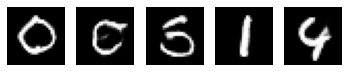

Epoch 25


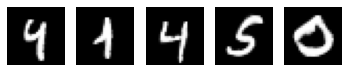

Epoch 26


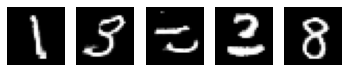

Epoch 27


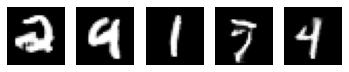

Epoch 28


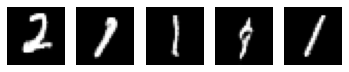

Epoch 29


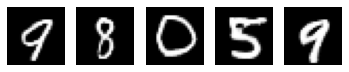

Epoch 30


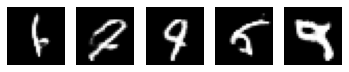

Epoch 31


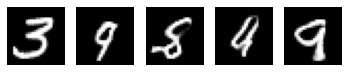

Epoch 32


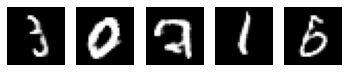

Epoch 33


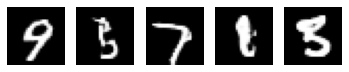

Epoch 34


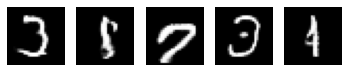

Epoch 35


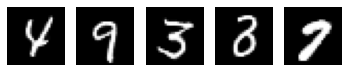

Epoch 36


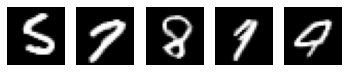

Epoch 37


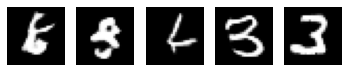

Epoch 38


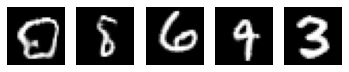

Epoch 39


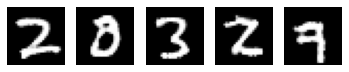

Epoch 40


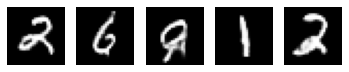

Epoch 41


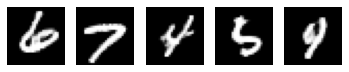

Epoch 42


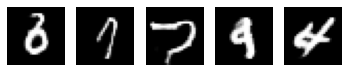

Epoch 43


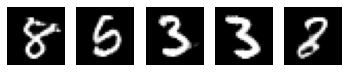

Epoch 44


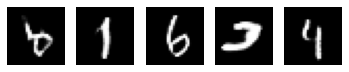

Epoch 45


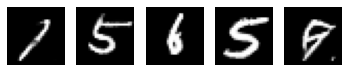

Epoch 46


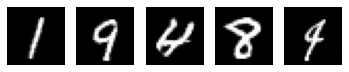

Epoch 47


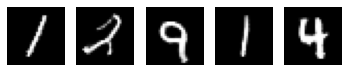

Epoch 48


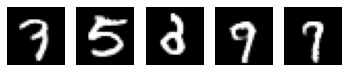

Epoch 49


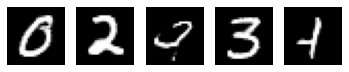

Epoch 50


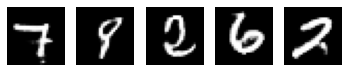

In [9]:
index_list = list(range(1,sample_size+1))

for e in range(1, epochs+1):
    print('Epoch', e)
    
    for j in range(sample_size):
        plt.subplot(1,5, index_list[j])
        plt.imshow(imgs[(iterations*e)-1][j].reshape(28,28), cmap='gray')
        plt.axis('off')

    plt.show()

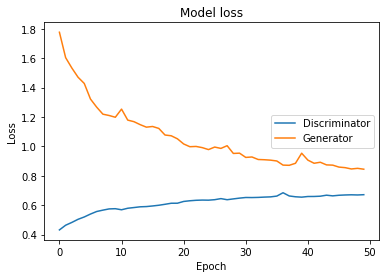

In [10]:
plt.plot(total_d_losses)
plt.plot(total_g_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')